In [ ]:
import sys, os, json, math, time, torch, random, warnings
import numpy as np
import torch.nn as nn
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from nltk.translate.bleu_score import corpus_bleu
from transformers import AutoTokenizer
warnings.filterwarnings("ignore")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CONFIG = {
    # Paths
    "data_root": "/kaggle/input/i2t-dataset/data/data/data",
    "json_file": "train/dataset.json",
    "checkpoint_path": "/kaggle/input/v5-25epoch/pytorch/default/1/resnet_safe_gradual_best.pth",
    
    # Architecture
    "encoder_type": "resnet101",
    "encoder_dim": 2048,
    "embed_dim": 512,
    "n_heads": 8,
    "n_layers": 3,
    "ffn_dim": 2048,
    "dropout": 0.1,
    
    # Learning Rates
    "encoder_lr": 2e-6,
    "decoder_lr": 2e-5,
    "weight_decay": 0.01,
    
    # Training
    "batch_size": 12,
    "num_workers": 4,
    "epochs": 40,
    "start_epoch": 11,        # ✅ Bắt đầu từ epoch 11
    "max_samples": 60000,
    "gradient_accumulation_steps": 4,
    
    # Phases
    "phase1_epochs": 15,      # Ep 12-15 (optimized)
    "phase2_epochs": 26,      # Ep 16-26
    "phase3_epochs": 40,      # Ep 27-40
    
    # Image
    "target_h": 224,
    "min_w": 224,
    "max_w": 1890,
    "max_w_batch": 1280,
    
    # Inference
    "beam_size": 5,
    "repetition_penalty": 1.2,
    "length_penalty": 0.6,
    
    # Optimization
    "use_amp": True,
    "label_smoothing": 0.0,
    "clip_grad_norm": 1.0,
    "early_stopping_patience": 3,
    "eval_samples": 2400,
    "warmup_epochs": 3,
}

print("\n" + "="*70)
print("🛡️ SAFE GRADUAL FINE-TUNING (FROM EPOCH 11)")
print("="*70)
print(f"🖥️  Device: {device}")
print(f"\n📚 3-PHASE PLAN (OPTIMIZED):")
print(f"   Phase 1 (Ep 12-15): FREEZE encoder, decoder LR={CONFIG['decoder_lr']:.1e}")
print(f"   Phase 2 (Ep 16-26): Encoder LR={CONFIG['encoder_lr']*2.5:.1e}, Decoder LR={CONFIG['decoder_lr']:.1e}")
print(f"   Phase 3 (Ep 27-40): Encoder LR={CONFIG['encoder_lr']:.1e}, Decoder LR={CONFIG['decoder_lr']:.1e}")
print(f"   🎯 Eval samples: {CONFIG['eval_samples']}, Early stop: {CONFIG['early_stopping_patience']} epochs")
print("="*70 + "\n")


🛡️ SAFE GRADUAL FINE-TUNING (FROM EPOCH 11)
🖥️  Device: cuda

📚 3-PHASE PLAN (OPTIMIZED):
   Phase 1 (Ep 12-15): FREEZE encoder, decoder LR=2.0e-05
   Phase 2 (Ep 16-26): Encoder LR=5.0e-06, Decoder LR=2.0e-05
   Phase 3 (Ep 27-40): Encoder LR=2.0e-06, Decoder LR=2.0e-05
   🎯 Eval samples: 2400, Early stop: 3 epochs



In [ ]:
tokenizer = AutoTokenizer.from_pretrained("vinai/bartpho-word")
print(f"✅ Tokenizer: {tokenizer.vocab_size} tokens")

class DynamicWidthTransform:
    def __init__(self, target_h, min_w, max_w, is_train=True):
        self.target_h = target_h
        self.min_w = min_w
        self.max_w = max_w
        if is_train:
            self.transform = A.Compose([
                A.Rotate(limit=5, p=0.3),
                A.RandomBrightnessContrast(p=0.3),
                A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                ToTensorV2()
            ])
        else:
            self.transform = A.Compose([
                A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                ToTensorV2()
            ])
    
    def __call__(self, img_pil):
        w, h = img_pil.size
        scale = self.target_h / h
        new_w = int(w * scale)
        new_w = max(self.min_w, min(new_w, self.max_w))
        img_pil = img_pil.resize((new_w, self.target_h), Image.Resampling.BICUBIC)
        img_array = np.array(img_pil)
        transformed = self.transform(image=img_array)["image"]
        return transformed, new_w

class ImageTextDataset(Dataset):
    def __init__(self, root_dir, json_file, tokenizer, transform=None, max_samples=None):
        self.root_dir = root_dir
        self.transform = transform
        self.tokenizer = tokenizer
        
        full_path = os.path.join(root_dir, json_file)
        with open(full_path, 'r', encoding='utf-8') as f:
            data = json.load(f)["data"]
        
        self.data = data[:max_samples] if max_samples else data
        
        if len(self.data) > 0:
            sample = self.data[0]
            img_rel_path = sample.get('image_path', '').replace('\\', '/')
            full_img_path = os.path.join(root_dir, img_rel_path)
            if os.path.exists(full_img_path):
                self.image_base = root_dir
            else:
                parent_dir = os.path.dirname(root_dir)
                alt_path = os.path.join(parent_dir, img_rel_path)
                self.image_base = parent_dir if os.path.exists(alt_path) else root_dir
        else:
            self.image_base = root_dir
    
    def __getitem__(self, idx):
        item = self.data[idx]
        img_rel_path = item['image_path'].replace('\\', '/')
        img_path = os.path.join(self.image_base, img_rel_path)
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image, img_width = self.transform(image)
        else:
            img_width = image.size[0]
        
        target_text = item['target_text']
        encoding = self.tokenizer(target_text, add_special_tokens=True, return_tensors='pt')
        ids = encoding['input_ids'].squeeze(0)
        return image, ids, target_text, img_width
    
    def __len__(self):
        return len(self.data)

def collate_fn(data):
    data.sort(key=lambda x: len(x[1]), reverse=True)
    images, captions, raw_texts, img_widths = zip(*data)
    max_width_in_batch = min(max(img_widths), CONFIG['max_w_batch'])
    batch_size = len(images)
    padded_images = torch.zeros(batch_size, 3, CONFIG['target_h'], max_width_in_batch)
    for i, (img, w) in enumerate(zip(images, img_widths)):
        actual_w = min(w, max_width_in_batch)
        padded_images[i, :, :, :actual_w] = img[:, :, :actual_w]
    lengths = [len(cap) for cap in captions]
    targets = torch.full((len(captions), max(lengths)), tokenizer.pad_token_id, dtype=torch.long)
    for i, cap in enumerate(captions):
        targets[i, :lengths[i]] = cap[:lengths[i]]
    return padded_images, targets, lengths, raw_texts

print("✅ Dataset ready")

config.json:   0%|          | 0.00/897 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

bpe.codes: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

✅ Tokenizer: 64000 tokens
✅ Dataset ready


In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=500):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))
    def forward(self, x):
        return x + self.pe[:, :x.size(1), :]

class ResNetEncoder(nn.Module):
    def __init__(self):
        super(ResNetEncoder, self).__init__()
        import torchvision.models as models
        resnet = models.resnet101(pretrained=True)
        self.features = nn.Sequential(*list(resnet.children())[:-2])
    def forward(self, x):
        return self.features(x)

class ResNetEncoderCustomDecoder(nn.Module):
    def __init__(self, encoder_dim, vocab_size, embed_dim, n_heads, n_layers, ffn_dim, dropout=0.1):
        super(ResNetEncoderCustomDecoder, self).__init__()
        self.encoder = ResNetEncoder()
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, None))
        self.enc_project = nn.Linear(encoder_dim, embed_dim)
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.pos_encoder = PositionalEncoding(embed_dim)
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=embed_dim, nhead=n_heads, dim_feedforward=ffn_dim,
            dropout=dropout, batch_first=True
        )
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=n_layers)
        self.fc_out = nn.Linear(embed_dim, vocab_size)
        self.dropout = nn.Dropout(dropout)
        self.embed_dim = embed_dim

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def forward(self, images, captions):
        features = self.encoder(images)
        features = self.adaptive_pool(features)
        B, C, _, W = features.shape
        memory = features.squeeze(2).permute(0, 2, 1)
        memory = self.enc_project(memory)
        tgt_mask = self.generate_square_subsequent_mask(captions.size(1)).to(captions.device)
        tgt_padding_mask = (captions == tokenizer.pad_token_id).to(captions.device)
        tgt = self.embedding(captions) * math.sqrt(self.embed_dim)
        tgt = self.pos_encoder(tgt)
        output = self.transformer_decoder(tgt=tgt, memory=memory, tgt_mask=tgt_mask,
                                         tgt_key_padding_mask=tgt_padding_mask)
        output = self.fc_out(output)
        return output

print("✅ Model (512D)")

✅ Model (512D)


In [ ]:
full_json_path = os.path.join(CONFIG["data_root"], CONFIG["json_file"])
with open(full_json_path, 'r', encoding='utf-8') as f:
    all_data = json.load(f)["data"][:CONFIG["max_samples"]]

total_samples = len(all_data)
train_ratio = 0.7
train_size = int(train_ratio * total_samples)

indices = list(range(total_samples))
random.seed(42)
random.shuffle(indices)

train_indices = indices[:train_size]
val_indices = indices[train_size:]

print(f"📊 Train: {train_size} | Val: {len(val_indices)}")

train_transform = DynamicWidthTransform(CONFIG['target_h'], CONFIG['min_w'], CONFIG['max_w'], is_train=True)
val_transform = DynamicWidthTransform(CONFIG['target_h'], CONFIG['min_w'], CONFIG['max_w'], is_train=False)

train_dataset_full = ImageTextDataset(CONFIG["data_root"], CONFIG["json_file"], tokenizer, train_transform, CONFIG["max_samples"])
train_dataset = torch.utils.data.Subset(train_dataset_full, train_indices)

val_dataset_full = ImageTextDataset(CONFIG["data_root"], CONFIG["json_file"], tokenizer, val_transform, CONFIG["max_samples"])
val_dataset = torch.utils.data.Subset(val_dataset_full, val_indices)

train_loader = DataLoader(train_dataset, batch_size=CONFIG["batch_size"], shuffle=True,
                          num_workers=CONFIG["num_workers"], collate_fn=collate_fn,
                          pin_memory=True, persistent_workers=True if CONFIG["num_workers"] > 0 else False)

val_loader = DataLoader(val_dataset, batch_size=CONFIG["batch_size"], shuffle=False,
                        num_workers=CONFIG["num_workers"], collate_fn=collate_fn,
                        pin_memory=True, persistent_workers=True if CONFIG["num_workers"] > 0 else False)

print("\n" + "="*70)
print("📦 LOADING CHECKPOINT")
print("="*70)

# Initialize model
model = ResNetEncoderCustomDecoder(
    encoder_dim=CONFIG["encoder_dim"],
    vocab_size=tokenizer.vocab_size,
    embed_dim=CONFIG["embed_dim"],
    n_heads=CONFIG["n_heads"],
    n_layers=CONFIG["n_layers"],
    ffn_dim=CONFIG["ffn_dim"],
    dropout=CONFIG["dropout"]
).to(device)

# Load checkpoint
checkpoint = torch.load(CONFIG["checkpoint_path"], map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
prev_bleu = checkpoint.get('bleu', 0)
prev_epoch = checkpoint.get('epoch', 0)

print(f"✅ Checkpoint loaded!")
print(f"   Epoch: {prev_epoch} | BLEU: {prev_bleu:.4f}")

# Separate params
encoder_params = []
decoder_params = []

for name, param in model.named_parameters():
    if 'encoder.features' in name:
        encoder_params.append(param)
    else:
        decoder_params.append(param)

print(f"\n📊 Params: Encoder {len(encoder_params)} | Decoder {len(decoder_params)}")

# Optimizer
optimizer = torch.optim.AdamW([
    {'params': encoder_params, 'lr': 0.0},  # Frozen initially
    {'params': decoder_params, 'lr': CONFIG['decoder_lr']}
], weight_decay=CONFIG['weight_decay'])

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3, verbose=True
)

criterion = nn.CrossEntropyLoss(
    ignore_index=tokenizer.pad_token_id,
    label_smoothing=CONFIG['label_smoothing']
)

scaler = torch.cuda.amp.GradScaler() if CONFIG["use_amp"] else None

print(f"\n✅ Ready to train!")
print("="*70)

📊 Train: 42000 | Val: 18000

📦 LOADING CHECKPOINT


Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:00<00:00, 199MB/s]  


✅ Checkpoint loaded!
   Epoch: 14 | BLEU: 0.2178

📊 Params: Encoder 312 | Decoder 59

✅ Ready to train!


In [ ]:
def beam_search(model, image, tokenizer, beam_size=5, max_len=50,
                length_penalty=0.6, repetition_penalty=1.2):
    model.eval()
    with torch.no_grad():
        features = model.encoder(image)
        features = model.adaptive_pool(features)
        B, C, _, W = features.shape
        memory = features.squeeze(2).permute(0, 2, 1)
        memory = model.enc_project(memory)
    beams = [([tokenizer.bos_token_id], 0.0)]
    for step in range(max_len):
        new_beams = []
        for seq, score in beams:
            if seq[-1] == tokenizer.eos_token_id:
                new_beams.append((seq, score))
                continue
            tgt_tensor = torch.LongTensor(seq).unsqueeze(0).to(image.device)
            tgt_mask = model.generate_square_subsequent_mask(tgt_tensor.size(1)).to(image.device)
            tgt_emb = model.embedding(tgt_tensor) * math.sqrt(model.embed_dim)
            tgt_emb = model.pos_encoder(tgt_emb)
            with torch.no_grad():
                output = model.transformer_decoder(tgt_emb, memory, tgt_mask=tgt_mask)
                output = model.fc_out(output)
                log_probs = torch.log_softmax(output[0, -1, :], dim=-1)
            for token_id in set(seq):
                if token_id not in [tokenizer.bos_token_id, tokenizer.eos_token_id, tokenizer.pad_token_id]:
                    log_probs[token_id] /= repetition_penalty
            top_log_probs, top_indices = torch.topk(log_probs, beam_size)
            for log_prob, idx in zip(top_log_probs, top_indices):
                new_seq = seq + [idx.item()]
                new_score = score + log_prob.item()
                new_beams.append((new_seq, new_score))
        beams = sorted(new_beams, key=lambda x: x[1] / (len(x[0]) ** length_penalty), reverse=True)[:beam_size]
        if all(seq[-1] == tokenizer.eos_token_id for seq, _ in beams):
            break
    best_seq = max(beams, key=lambda x: x[1] / (len(x[0]) ** length_penalty))[0]
    return best_seq

def evaluate_metrics(model, val_dataset, tokenizer, num_samples=1000):
    model.eval()
    val_size = len(val_dataset)
    num_eval = min(num_samples, val_size)
    eval_indices = random.sample(range(val_size), num_eval)
    references, hypotheses = [], []
    print(f"\n{'-'*20} VALIDATION ({num_eval}/{val_size}) {'-'*20}")
    with torch.no_grad():
        for i, idx in enumerate(eval_indices):
            image, _, target_text, _ = val_dataset[idx]
            with torch.cuda.amp.autocast(enabled=CONFIG["use_amp"]):
                image = image.unsqueeze(0).to(device)
                pred_tokens = beam_search(model, image, tokenizer,
                                         beam_size=CONFIG['beam_size'],
                                         length_penalty=CONFIG['length_penalty'],
                                         repetition_penalty=CONFIG['repetition_penalty'])
            pred_text = tokenizer.decode(pred_tokens, skip_special_tokens=True)
            references.append([target_text.lower().split()])
            hypotheses.append(pred_text.lower().split())
            if i < 2:
                print(f"[Sample {i+1}]")
                print(f"  Target: {target_text}")
                print(f"  Pred  : {pred_text}\n")
            if (i + 1) % 500 == 0:
                print(f"  ... {i+1}/{num_eval} done")
    bleu4 = corpus_bleu(references, hypotheses)
    print(f">>> ✅ BLEU-4: {bleu4:.4f}")
    print(f"{'-'*60}\n")
    model.train()
    return bleu4

print("✅ Evaluation ready")

✅ Evaluation ready


In [ ]:
# def get_warmup_lr(epoch, base_lr, warmup_epochs):
#     if epoch < warmup_epochs:
#         return base_lr * (epoch + 1) / warmup_epochs
#     return base_lr

# print("\n" + "="*70)
# print("🚀 3-PHASE TRAINING START")
# print("="*70)

# OUTPUT_DIR = "/kaggle/working"
# best_bleu = prev_bleu  # Start from checkpoint BLEU
# no_improvement = 0

# print(f"Starting BLEU: {best_bleu:.4f} from epoch {prev_epoch}\n")

# for epoch in range(CONFIG["start_epoch"], CONFIG["epochs"]):
    
#     # Phase control
#     current_phase = 1
#     if epoch < CONFIG['phase1_epochs']:
#         current_phase = 1
#         for param in encoder_params:
#             param.requires_grad = False
#         warmup_progress = epoch - CONFIG['start_epoch']
#         dec_lr = get_warmup_lr(warmup_progress, CONFIG['decoder_lr'], CONFIG['warmup_epochs'])
#         optimizer.param_groups[0]['lr'] = 0.0
#         optimizer.param_groups[1]['lr'] = dec_lr
#         phase_name = f"PHASE 1 (Frozen Encoder) - Warmup {warmup_progress+1}/{CONFIG['warmup_epochs']}"
#     elif epoch < CONFIG['phase2_epochs']:
#         current_phase = 2
#         if epoch == CONFIG['phase1_epochs']:
#             print("\n" + "="*70)
#             print("🔓 PHASE 2: Unfreezing encoder (Higher LR)")
#             print("="*70)
#             for param in encoder_params:
#                 param.requires_grad = True
#         optimizer.param_groups[0]['lr'] = CONFIG['encoder_lr'] * 2.5  # 5e-6 instead of 1e-6
#         optimizer.param_groups[1]['lr'] = CONFIG['decoder_lr']
#         phase_name = "PHASE 2 (Moderate Encoder LR)"
#     else:
#         current_phase = 3
#         if epoch == CONFIG['phase2_epochs']:
#             print("\n" + "="*70)
#             print("⚡ PHASE 3: Normal dual LR")
#             print("="*70)
#         optimizer.param_groups[0]['lr'] = CONFIG['encoder_lr']
#         optimizer.param_groups[1]['lr'] = CONFIG['decoder_lr']
#         phase_name = "PHASE 3 (Normal Dual LR)"
    
#     # Training
#     model.train()
#     total_loss = 0
#     start_time = time.time()
#     optimizer.zero_grad()
    
#     print(f"\n{'='*70}")
#     print(f"Epoch {epoch+1}/{CONFIG['epochs']} - {phase_name}")
#     print(f"LR: Enc={optimizer.param_groups[0]['lr']:.2e}, Dec={optimizer.param_groups[1]['lr']:.2e}")
#     print(f"{'='*70}")
    
#     for i, (imgs, captions, lengths, raw_texts) in enumerate(train_loader):
#         imgs = imgs.to(device, non_blocking=True)
#         captions = captions.to(device, non_blocking=True)
#         tgt_input = captions[:, :-1]
#         tgt_output = captions[:, 1:]
        
#         if CONFIG["use_amp"]:
#             with torch.cuda.amp.autocast():
#                 outputs = model(imgs, tgt_input)
#                 loss = criterion(outputs.reshape(-1, tokenizer.vocab_size), tgt_output.reshape(-1))
#                 loss = loss / CONFIG["gradient_accumulation_steps"]
#         else:
#             outputs = model(imgs, tgt_input)
#             loss = criterion(outputs.reshape(-1, tokenizer.vocab_size), tgt_output.reshape(-1))
#             loss = loss / CONFIG["gradient_accumulation_steps"]
        
#         if CONFIG["use_amp"]:
#             scaler.scale(loss).backward()
#         else:
#             loss.backward()
        
#         if (i + 1) % CONFIG["gradient_accumulation_steps"] == 0:
#             if CONFIG["use_amp"]:
#                 scaler.unscale_(optimizer)
#                 torch.nn.utils.clip_grad_norm_(model.parameters(), CONFIG['clip_grad_norm'])
#                 scaler.step(optimizer)
#                 scaler.update()
#             else:
#                 torch.nn.utils.clip_grad_norm_(model.parameters(), CONFIG['clip_grad_norm'])
#                 optimizer.step()
#             optimizer.zero_grad()
        
#         total_loss += loss.item() * CONFIG["gradient_accumulation_steps"]
        
#         if i % 200 == 0:
#             print(f"  Step {i}/{len(train_loader)} | Loss: {loss.item() * CONFIG['gradient_accumulation_steps']:.4f}")
    
#     avg_loss = total_loss / len(train_loader)
#     elapsed = time.time() - start_time
#     print(f"\n✅ Epoch {epoch+1} | Loss: {avg_loss:.4f} | Time: {elapsed/60:.1f}m")
    
#     # Validation
#     current_bleu = evaluate_metrics(model, val_dataset, tokenizer, num_samples=CONFIG['eval_samples'])
#     scheduler.step(avg_loss)
    
#     if torch.cuda.is_available():
#         torch.cuda.empty_cache()
    
#     # Save best
#     if current_bleu > best_bleu:
#         improvement = (current_bleu - prev_bleu) * 100
#         best_bleu = current_bleu
#         no_improvement = 0
#         torch.save({
#             'epoch': epoch + 1,
#             'phase': current_phase,
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             'bleu': best_bleu,
#             'config': CONFIG
#         }, os.path.join(OUTPUT_DIR, "resnet_safe_gradual_best.pth"))
#         print(f"💾 BEST! BLEU: {best_bleu:.4f} (↑ {improvement:.2f} pts from checkpoint)\n")
#     else:
#         no_improvement += 1
#         print(f"⚠️ No improvement: {no_improvement} epoch(s)\n")
    
#     # Early stopping (Phase 3 only)
#     if current_phase == 3 and no_improvement >= CONFIG['early_stopping_patience']:
#         print(f"🛑 Early stopping")
#         break
    
#     # Periodic save
#     if (epoch+1) % 5 == 0:
#         torch.save({
#             'epoch': epoch + 1,
#             'model_state_dict': model.state_dict(),
#             'bleu': current_bleu,
#         }, os.path.join(OUTPUT_DIR, f"resnet_safe_epoch_{epoch+1}.pth"))

# print("\n" + "="*70)
# print("🎉 TRAINING COMPLETED!")
# print(f"🏆 Best BLEU: {best_bleu:.4f}")
# print(f"📈 Total improvement: +{(best_bleu-prev_bleu)*100:.2f} points")
# print("="*70)

In [ ]:
# print("\n" + "="*70)
# print("🔬 FINAL EVALUATION - FULL VALIDATION SET")
# print("="*70)

# # Load best model
# best_checkpoint = torch.load(os.path.join(OUTPUT_DIR, "/kaggle/input/v3-reset3/pytorch/default/1/resnet_768d_dual_lr_best.pth"))
# model_new.load_state_dict(best_checkpoint['model_state_dict'])
# print(f"✅ Loaded best model from epoch {best_checkpoint['epoch']}")

# # Evaluate on FULL val set
# final_bleu = evaluate_metrics(model_new, val_dataset, tokenizer, num_samples=len(val_dataset))

# # Sample predictions
# print("\n🔍 SAMPLE PREDICTIONS:")
# model_new.eval()
# sample_indices = random.sample(range(len(val_dataset)), 5)

# for i, idx in enumerate(sample_indices):
#     image, _, target_text, _ = val_dataset[idx]
    
#     with torch.no_grad():
#         with torch.cuda.amp.autocast(enabled=CONFIG["use_amp"]):
#             image = image.unsqueeze(0).to(device)
#             pred_tokens = beam_search(model_new, image, tokenizer,
#                                      beam_size=CONFIG['beam_size'],
#                                      max_len=70,
#                                      length_penalty=CONFIG['length_penalty'],
#                                      repetition_penalty=CONFIG['repetition_penalty'])
    
#     pred_text = tokenizer.decode(pred_tokens, skip_special_tokens=True)
    
#     print(f"\n[Example {i+1}]")
#     print(f"Target: {target_text}")
#     print(f"Prediction: {pred_text}")

# print("\n" + "="*70)
# print("✅ ALL DONE!")
# print("="*70)

📦 Loading model from: /kaggle/input/v5-25epoch/pytorch/default/2/resnet_safe_gradual_best.pth
✅ Model loaded! Epoch: 20 | BLEU: 0.2889

🔍 TESTING WITH SINGLE IMAGE
Image: /kaggle/input/i2t-dataset/data/data/data/train/images/000057.png



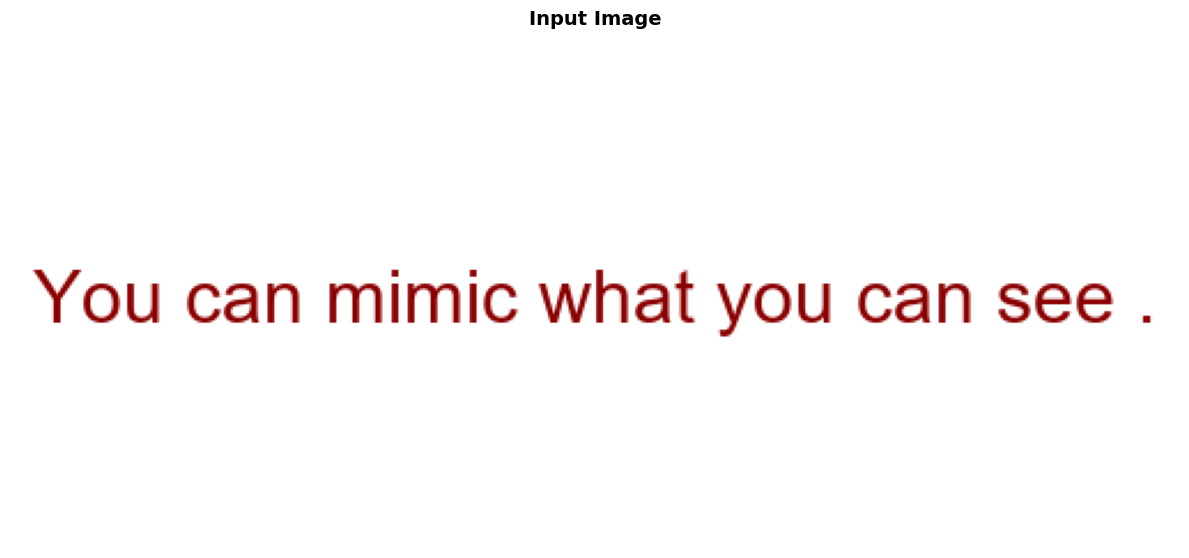

📝 Predicted Caption:
   Bạn có thể bắt chước những gì bạn có thể thấy .

🔍 TESTING WITH MULTIPLE IMAGES

[Image 1] 000001.png
  Caption: Rachel Botsk : Khoa học về khoa học đằng sau một thời tiết .

[Image 2] 000003.png
  Caption: Hôm nay tôi muốn nói với các bạn về sự nỗ lực khoa học mà bạn thấy trong giấy .

[Image 3] 000023.png
  Caption: khí metan toàn , hay tiêu tốn khoảng 2,000 lần điều gì xảy ra trong xe của bạn .

✅ TESTING COMPLETED!


In [ ]:
def load_model_from_checkpoint(checkpoint_path, device):
    """Load model từ checkpoint"""
    print(f"📦 Loading model from: {checkpoint_path}")
    
    # Initialize model
    model = ResNetEncoderCustomDecoder(
        encoder_dim=CONFIG["encoder_dim"],
        vocab_size=tokenizer.vocab_size,
        embed_dim=CONFIG["embed_dim"],
        n_heads=CONFIG["n_heads"],
        n_layers=CONFIG["n_layers"],
        ffn_dim=CONFIG["ffn_dim"],
        dropout=CONFIG["dropout"]
    ).to(device)
    
    # Load checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    bleu = checkpoint.get('bleu', 0)
    epoch = checkpoint.get('epoch', 0)
    print(f"✅ Model loaded! Epoch: {epoch} | BLEU: {bleu:.4f}\n")
    
    return model

def predict_single_image(model, image_path, tokenizer, device, 
                        beam_size=5, max_len=70,
                        length_penalty=0.6, repetition_penalty=1.2):
    """Dự đoán caption cho 1 ảnh"""
    
    # Load và preprocess ảnh
    image = Image.open(image_path).convert('RGB')
    transform = DynamicWidthTransform(CONFIG['target_h'], CONFIG['min_w'], 
                                     CONFIG['max_w'], is_train=False)
    image_tensor, img_width = transform(image)
    image_tensor = image_tensor.unsqueeze(0).to(device)
    
    # Predict với beam search
    model.eval()
    with torch.no_grad():
        with torch.cuda.amp.autocast(enabled=CONFIG["use_amp"]):
            pred_tokens = beam_search(model, image_tensor, tokenizer,
                                     beam_size=beam_size,
                                     max_len=max_len,
                                     length_penalty=length_penalty,
                                     repetition_penalty=repetition_penalty)
    
    # Decode tokens thành text
    pred_text = tokenizer.decode(pred_tokens, skip_special_tokens=True)
    
    return pred_text



# 1. Load model từ checkpoint tốt nhất
MODEL_PATH = "/kaggle/input/v5-25epoch/pytorch/default/2/resnet_safe_gradual_best.pth"  # Thay đổi path này
# Hoặc dùng checkpoint input: "/kaggle/input/v5-25epoch/pytorch/default/1/resnet_safe_gradual_best.pth"

loaded_model = load_model_from_checkpoint(MODEL_PATH, device)

# 2. Test với 1 ảnh bất kỳ
TEST_IMAGE_PATH = "/kaggle/input/i2t-dataset/data/data/data/train/images/000057.png"  # Thay đổi path này

print("="*70)
print("🔍 TESTING WITH SINGLE IMAGE")
print("="*70)
print(f"Image: {TEST_IMAGE_PATH}\n")

# Hiển thị ảnh (nếu dùng matplotlib)
try:
    import matplotlib.pyplot as plt
    img_display = Image.open(TEST_IMAGE_PATH).convert('RGB')
    plt.figure(figsize=(12, 6))
    plt.imshow(img_display)
    plt.axis('off')
    plt.title("Input Image", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
except:
    print("⚠️ Matplotlib not available, skipping image display")

# Predict
prediction = predict_single_image(
    loaded_model, 
    TEST_IMAGE_PATH, 
    tokenizer, 
    device,
    beam_size=CONFIG['beam_size'],
    max_len=70,
    length_penalty=CONFIG['length_penalty'],
    repetition_penalty=CONFIG['repetition_penalty']
)

print(f"📝 Predicted Caption:\n   {prediction}")
print("="*70)

# 3. Test với nhiều ảnh (Optional)
print("\n" + "="*70)
print("🔍 TESTING WITH MULTIPLE IMAGES")
print("="*70)

# Danh sách các ảnh muốn test
TEST_IMAGES = [
    "/kaggle/input/i2t-dataset/data/data/data/train/images/000001.png",
    "/kaggle/input/i2t-dataset/data/data/data/train/images/000003.png",
    "/kaggle/input/i2t-dataset/data/data/data/train/images/000023.png",
]

for idx, img_path in enumerate(TEST_IMAGES, 1):
    if os.path.exists(img_path):
        pred = predict_single_image(loaded_model, img_path, tokenizer, device)
        print(f"\n[Image {idx}] {os.path.basename(img_path)}")
        print(f"  Caption: {pred}")
    else:
        print(f"\n[Image {idx}] ⚠️ File not found: {img_path}")

print("\n" + "="*70)
print("✅ TESTING COMPLETED!")
print("="*70)

In [9]:
!pip install gradio torch torchvision transformers albumentations Pillow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.6/68.6 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.2 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of mkl-fft to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of mkl-random to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of mkl-umath to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 112.9 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 92.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/66

In [10]:
import torch
import torch.nn as nn
import math
import numpy as np
import gradio as gr
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
from transformers import AutoTokenizer
import torchvision.models as models

# --- Giữ nguyên cấu trúc Model từ file train của bạn ---
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=500):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))
    def forward(self, x):
        return x + self.pe[:, :x.size(1), :]

class ResNetEncoder(nn.Module):
    def __init__(self):
        super(ResNetEncoder, self).__init__()
        resnet = models.resnet101(weights=None)
        self.features = nn.Sequential(*list(resnet.children())[:-2])
    def forward(self, x):
        return self.features(x)

class ResNetEncoderCustomDecoder(nn.Module):
    def __init__(self, encoder_dim, vocab_size, embed_dim, n_heads, n_layers, ffn_dim, dropout=0.1):
        super(ResNetEncoderCustomDecoder, self).__init__()
        self.encoder = ResNetEncoder()
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, None))
        self.enc_project = nn.Linear(encoder_dim, embed_dim)
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.pos_encoder = PositionalEncoding(embed_dim)
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=embed_dim, nhead=n_heads, dim_feedforward=ffn_dim,
            dropout=dropout, batch_first=True
        )
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=n_layers)
        self.fc_out = nn.Linear(embed_dim, vocab_size)
        self.embed_dim = embed_dim

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

In [11]:
# --- CẤU HÌNH ---
MODEL_PATH ="/kaggle/input/v5-25epoch/pytorch/default/2/resnet_safe_gradual_best.pth" # Thay bằng đường dẫn file của bạn
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Tokenizer & Model
tokenizer = AutoTokenizer.from_pretrained("vinai/bartpho-word")
model = ResNetEncoderCustomDecoder(
    encoder_dim=2048, vocab_size=tokenizer.vocab_size, embed_dim=512,
    n_heads=8, n_layers=3, ffn_dim=2048
).to(device)

# Load Weights
checkpoint = torch.load(MODEL_PATH, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

def predict(img):
    if img is None: return "Chưa có ảnh"
    
    # Preprocess ảnh (Target Height 224 theo CONFIG của bạn)
    img_pil = Image.fromarray(img).convert('RGB')
    w, h = img_pil.size
    scale = 224 / h
    new_w = int(w * scale)
    new_w = max(224, min(new_w, 1890))
    img_resized = img_pil.resize((new_w, 224), Image.Resampling.BICUBIC)
    
    transform = A.Compose([
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ])
    img_tensor = transform(image=np.array(img_resized))["image"].unsqueeze(0).to(device)

    # Beam Search Dự đoán
    with torch.no_grad():
        features = model.encoder(img_tensor)
        features = model.adaptive_pool(features)
        memory = features.squeeze(2).permute(0, 2, 1)
        memory = model.enc_project(memory)
        
        beams = [([tokenizer.bos_token_id], 0.0)]
        for _ in range(70): # max_len
            new_beams = []
            for seq, score in beams:
                if seq[-1] == tokenizer.eos_token_id:
                    new_beams.append((seq, score))
                    continue
                tgt_tensor = torch.LongTensor(seq).unsqueeze(0).to(device)
                tgt_mask = model.generate_square_subsequent_mask(tgt_tensor.size(1)).to(device)
                tgt_emb = model.embedding(tgt_tensor) * math.sqrt(512)
                tgt_emb = model.pos_encoder(tgt_emb)
                output = model.transformer_decoder(tgt_emb, memory, tgt_mask=tgt_mask)
                log_probs = torch.log_softmax(model.fc_out(output)[0, -1, :], dim=-1)
                
                top_probs, top_idxs = torch.topk(log_probs, 5) # beam_size=5
                for p, idx in zip(top_probs, top_idxs):
                    new_beams.append((seq + [idx.item()], score + p.item()))
            beams = sorted(new_beams, key=lambda x: x[1], reverse=True)[:5]
            if all(s[-1] == tokenizer.eos_token_id for s, _ in beams): break
    
    return tokenizer.decode(beams[0][0], skip_special_tokens=True)

# --- TẠO GIAO DIỆN GRADIO ---
interface = gr.Interface(
    fn=predict,
    inputs=gr.Image(),
    outputs=gr.Textbox(label="Kết quả mô tả ảnh (Vietnamese)"),
    title="App Mô tả Hình ảnh - Reset V5",
    description="Tải ảnh lên và đợi mô hình ResNet-Transformer dịch sang tiếng Việt."
)

interface.launch(inline=True, share=True)

* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://1d8714366c67532a68.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
